# Imports

In [1]:
import os
import json

import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import soundfile as sf
import librosa

import torch
from torch.utils.data import Dataset

# Read Data Set and Preprocessing

## Read Data Set

- Store all the training data in DATA_PATH
- Use the same name for audio file and label file, for example:
  - Audio file name: "audio-1.wav"
  - Label file name: "audio-1.json"
- For more details about audio and label format, see [Audio-Spectrum-Labeling-Toolset](https://github.com/Fangjun-Zhou/Audio-Spectrum-Labeling-Toolset)

## Preprocessing

- TIME_SCALE is the scale of time span for each window. For example, if TIME_SCALE is 1, then each window will be a square. The length of each window will be equal to the height of audioSpectrogram.
  - For species making longer sounds, increase TIME_SCALE to make sure their audio fits in the window.

In [2]:
# The path for all data sets.
DATA_PATH = "data"
# Spectrogram frequency sample rate.
N_FFT = 512
# Time scale for spectrogram.
TIME_SCALE = 3
# The intensity of the enhancement.
ENHANCE_FACTOR = 32

In [3]:
# Get all files in the data folder
dataFileNames = [f for f in os.listdir(DATA_PATH) if os.path.isfile(os.path.join(DATA_PATH, f))]
# Get all audio files with .wav extension
audioFileNames = [f for f in dataFileNames if f.endswith(".wav")]
# Get all label file names, replacing .wav with .json
labelFileNames = [f.replace(".wav", ".json") for f in audioFileNames]

# Check if all label files exist
for f in labelFileNames:
    if not os.path.isfile(os.path.join(DATA_PATH, f)):
        raise FileExistsError("Label file {} does not exist".format(f))

audioFileNames, labelFileNames

(['sample_chan0.wav'], ['sample_chan0.json'])

## Preprocess

- Read in audio data
- Convert the audio into spectrogram
- Slice the spectrogram into overlapping windows

### Spectrum Enhancement

The spectrogram is enhanced using following methods:

- Normalize the spectrogram to 0-1:
  - Subtract the entire spectrogram by the minimum value in the spectrogram so that the minimum value is 0.
  - Divide the entire spectrogram by the maximum value in the spectrogram so that the maximum value is 1.
- Enhance the spectrogram using $f(x) = 1 - (1-x)^{\text{ENHANCE\_FACTOR}}$

In [4]:
# TODO: Construct a funtion for this later
def GenerateSpectrogram(audioFileName):
    # Read the audio file
    audioData, sampleRate = sf.read(os.path.join(DATA_PATH, audioFileName))
    # Get the total time span of the audio file
    timeSpan = audioData.shape[0] / sampleRate

    # Generate the spectrogram of the audio file
    audioSpectrogram = np.abs(librosa.core.spectrum.stft(audioData, n_fft=N_FFT))

    # Get frequency bins
    spectrogramFrequencies = librosa.core.fft_frequencies(sr=sampleRate, n_fft=N_FFT)

    # Normalize the spectrogram
    audioSpectrogram -= np.amin(audioSpectrogram)
    audioSpectrogram /= np.amax(audioSpectrogram)

    # Preprocess the audio spectrogram for clearer visualization
    audioSpectrogram = 1 - (1-audioSpectrogram)**ENHANCE_FACTOR
    
    return audioSpectrogram, spectrogramFrequencies, timeSpan

In [5]:
def GetLabels(labelFileName):
    labelFileName = labelFileNames[0]
    # Read the label file in json format
    labelGroups = json.load(open(os.path.join(DATA_PATH, labelFileName)))
    labels = []
    for group in labelGroups:
        # Expand the labels
        labels.extend(group["dataSetLabels"])
    return labels

In [6]:

class SpectrumWindow:
    def __init__(
        self,
        spectrogramSlice: np.ndarray,
        startTime:float,
        endTime:float
    ):
        self.spectrogramSlice = spectrogramSlice
        self.startTime = startTime
        self.endTime = endTime
    
    def __repr__(self):
        return "SpectrumWindow(startTime={}, endTime={}, spectrogramSlice.shape={})".format(self.startTime, self.endTime, self.spectrogramSlice.shape)

In [7]:
def GetAudioWindows(audioSpectrogram: np.ndarray) -> list[SpectrumWindow]:
    """
    Get sliding windows of the audio spectrogram.
    """
    spectrogramHeight = audioSpectrogram.shape[0]
    spectrogramWidth = audioSpectrogram.shape[1]

    audioWindows: list[SpectrumWindow] = []
    sliceIndex = 0
    while True:
        # Get a window of the spectrogram
        startX = sliceIndex * (spectrogramHeight * TIME_SCALE // 2)
        # Break if startX is out of bounds
        if startX >= spectrogramWidth:
            break
        
        # Get the start and end time of the window
        startTime = (startX / spectrogramWidth) * timeSpan
        endTime = (startX + spectrogramHeight * TIME_SCALE) / spectrogramWidth * timeSpan
        
        spectrogramSlice = audioSpectrogram[:, startX:startX+int(spectrogramHeight*TIME_SCALE)]
        # 0-pad the spectrogram slice to make it square
        if spectrogramSlice.shape[1] < int(spectrogramHeight * TIME_SCALE):
            spectrogramSliceTmp = np.zeros((spectrogramHeight, int(spectrogramHeight * TIME_SCALE)))
            spectrogramSliceTmp[:, :spectrogramSlice.shape[1]] = spectrogramSlice
            spectrogramSlice = spectrogramSliceTmp
            
        audioWindow = SpectrumWindow(spectrogramSlice, startTime, endTime)
        audioWindows.append(audioWindow)
        
        sliceIndex += 1
    return audioWindows

### Inspect the Spectrogram Labels in one File

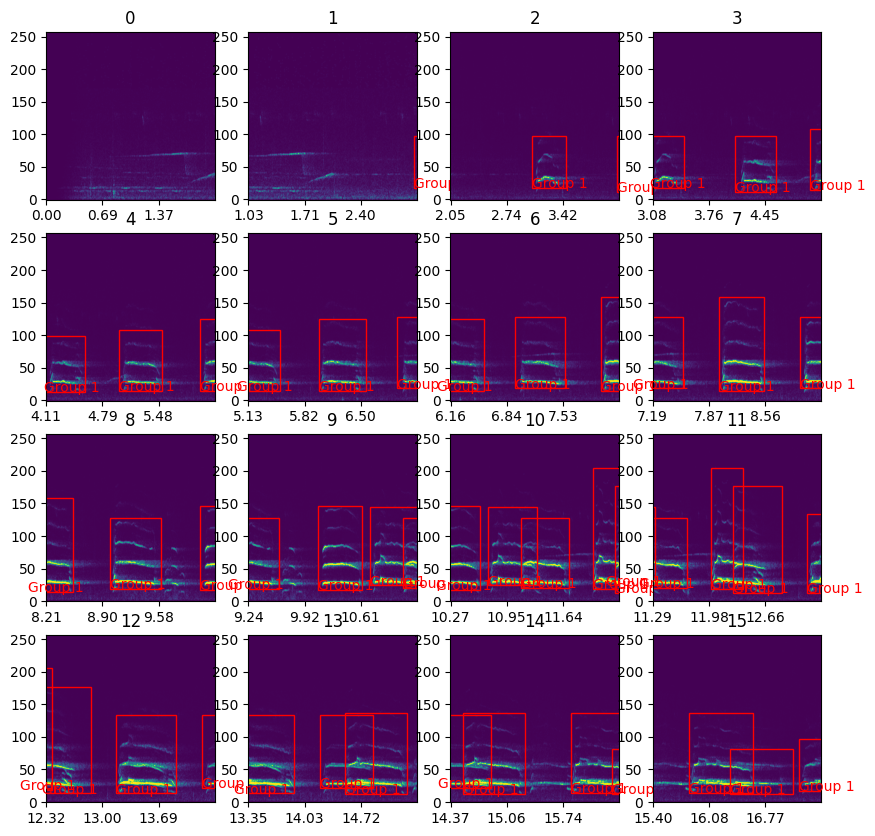

In [8]:
INSPECT_FILE_INDEX = 0

# Get the spectrogram of the audio file
audioSpectrogram, spectrogramFrequencies, timeSpan = GenerateSpectrogram(audioFileNames[INSPECT_FILE_INDEX])
# Get the labels of the audio file
labels = GetLabels(labelFileNames[INSPECT_FILE_INDEX])
# Split the audio file into windows
audioWindows = GetAudioWindows(audioSpectrogram)

# Plot 16 spectrogram slice
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    # Get a window of the spectrogram
    sliceIndex = i
    audioWindow = audioWindows[sliceIndex]
    spectrogramSlice = audioWindow.spectrogramSlice
    ax[i // 4, i % 4].imshow(spectrogramSlice, aspect="auto", origin="lower")
    ax[i // 4, i % 4].set_title("{}".format(i))
    # Set the x-axis to the time scale
    xticks = np.arange(0, spectrogramSlice.shape[1], spectrogramSlice.shape[1] // 3)
    xlabels = [
        "{:.2f}".format(
            audioWindow.startTime + (i / spectrogramSlice.shape[1]) * 
            (audioWindow.endTime - audioWindow.startTime)) for i in xticks]
    ax[i // 4, i % 4].set_xticks(xticks)
    ax[i // 4, i % 4].set_xticklabels(xlabels)
    # Draw all labels
    for label in labels:
        # Find the start and end coordinates of the label
        startX = int(
            (
                label["startTime"] - audioWindow.startTime
            )/(
                audioWindow.endTime - audioWindow.startTime
            ) * spectrogramSlice.shape[1]
        )
        endX = int(
            (
                label["endTime"] - audioWindow.startTime
            )/(
                audioWindow.endTime - audioWindow.startTime
            ) * spectrogramSlice.shape[1]
        )
        # Find y coordinates by finding the index of first value in spectrogramFrequencies > label frequency
        startY = np.argmax(spectrogramFrequencies > label["startFreq"])
        endY = np.argmax(spectrogramFrequencies > label["endFreq"])
        # Continue if startX > spectrogramSlice.shape[1] or endX < 0
        if startX > spectrogramSlice.shape[1] or endX < 0:
            continue
        # Draw the rectangle
        rect = Rectangle(
            (startX, startY),
            endX - startX,
            endY - startY,
            linewidth=1,
            edgecolor="r",
            facecolor="none"
        )
        ax[i // 4, i % 4].add_patch(rect)
        # Draw the label name
        ax[i // 4, i % 4].text(
            startX,
            startY,
            label["groupName"],
            color="r",
            fontsize=10
        )
plt.show()

## Generate Data Set (Selctive Search with ROI Filter)

In [9]:
class MappedLabel:
    def __init__(
        self,
        label: dict,
        startX: int,
        endX: int,
        startY: int,
        endY: int
    ):
        self.label = label
        self.startX = startX
        self.endX = endX
        self.startY = startY
        self.endY = endY
    
    def __repr__(self):
        return "MappedLabel(label={}, startX={}, endX={}, startY={}, endY={})".format(self.label, self.startX, self.endX, self.startY, self.endY)

def GetAvailableLabels(audioWindow: SpectrumWindow, labels: list) -> list:
    """
    Get all available labels for a given audio window
    """
    availableLabels = []
    # Find all labels in the window
    for label in labels:
        # Find the start and end coordinates of the label
        startX = int(
            (
                label["startTime"] - audioWindow.startTime
            )/(
                audioWindow.endTime - audioWindow.startTime
            ) * spectrogramSlice.shape[1]
        )
        endX = int(
            (
                label["endTime"] - audioWindow.startTime
            )/(
                audioWindow.endTime - audioWindow.startTime
            ) * spectrogramSlice.shape[1]
        )
        # Find y coordinates by finding the index of first value in spectrogramFrequencies > label frequency
        startY = np.argmax(spectrogramFrequencies > label["startFreq"])
        endY = np.argmax(spectrogramFrequencies > label["endFreq"])
        # Continue if startX > spectrogramSlice.shape[1] or endX < 0
        if startX > spectrogramSlice.shape[1] or endX < 0:
            continue
        label = MappedLabel(label, startX, endX, startY, endY)
        availableLabels.append(label)

    return availableLabels

In [10]:
class SelectiveSearcher:
    """
    Searcher to perform selective search.
    """
    def __init__(self):
        self.ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    def Search(self, image: np.ndarray) -> list:
        searchTarget = image
        # Convert searchTarget to float32
        searchTarget = searchTarget.astype(np.float32)
        searchTarget.reshape(
            1,
            audioWindow.spectrogramSlice.shape[0],
            audioWindow.spectrogramSlice.shape[1]
        )
        # Convert gray scale image to RGB
        searchTarget = cv2.cvtColor(searchTarget, cv2.COLOR_GRAY2RGB)
        self.ss.setBaseImage(searchTarget)
        self.ss.switchToSelectiveSearchFast()
        # Search
        rects = self.ss.process()
        
        return rects

### Inspect the Selective Search Results

In [13]:
INSPECT_FILE_INDEX = 0
INSPECT_WINDOW_INDEX = 5
# Load one audio file
# TODO: Replace audioFileNames[0] and labelFileNames[0] with different audio files
# Get the spectrogram of the audio file
audioSpectrogram, spectrogramFrequencies, timeSpan = GenerateSpectrogram(audioFileNames[INSPECT_FILE_INDEX])
# Get the labels of the audio file
labels = GetLabels(labelFileNames[INSPECT_FILE_INDEX])
# Split the audio file into windows
audioWindows = GetAudioWindows(audioSpectrogram)

# Get specified window
audioWindow = audioWindows[INSPECT_WINDOW_INDEX]
availableLabels: list[MappedLabel] = GetAvailableLabels(audioWindow, labels)

# Init searcher
selectiveSearcher = SelectiveSearcher()
rects = selectiveSearcher.Search(audioWindow.spectrogramSlice)
print("Found {} rectangles".format(len(rects)))

Found 111 rectangles


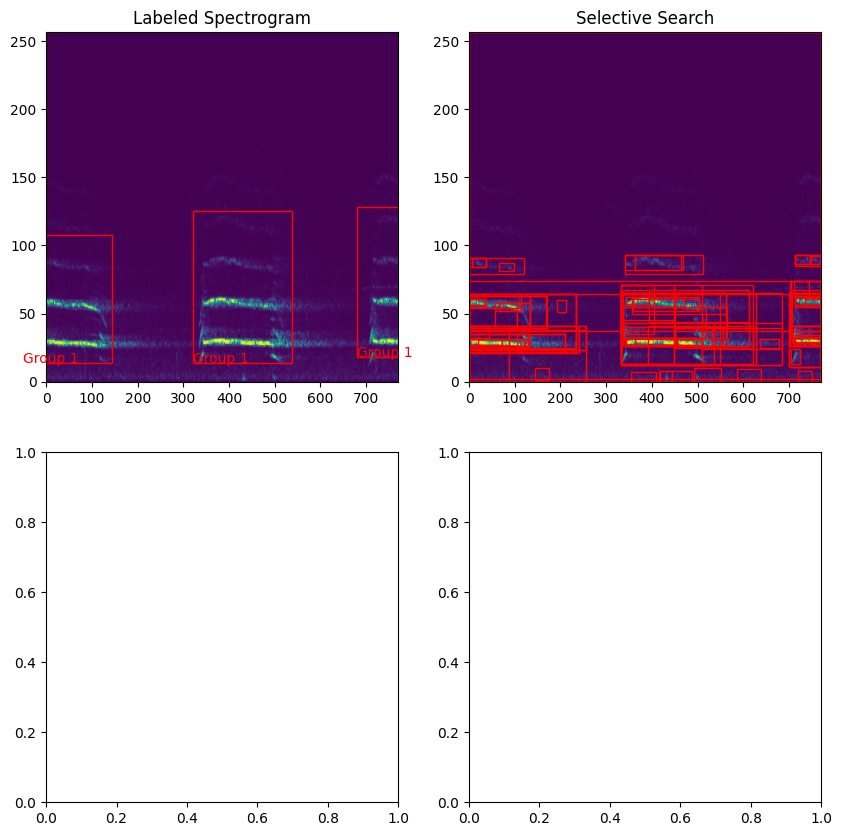

In [14]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(audioWindow.spectrogramSlice, aspect="auto", origin="lower")
ax[0, 0].set_title("Labeled Spectrogram")
for label in availableLabels:
    rect = Rectangle(
        (label.startX, label.startY),
        label.endX - label.startX,
        label.endY - label.startY,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax[0, 0].add_patch(rect)
    ax[0, 0].text(
        label.startX,
        label.startY,
        label.label["groupName"],
        color="r",
        fontsize=10
    )
ax[0, 1].imshow(audioWindow.spectrogramSlice, aspect="auto", origin="lower")
ax[0, 1].set_title("Selective Search")
for rect in rects:
    x, y, w, h = rect
    rect = Rectangle(
        (x, y),
        w,
        h,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax[0, 1].add_patch(rect)